In [45]:
using QuantEcon
P = [.4 .6
     .2 .8]
mc = MarkovChain(P)
s = mc_sample_path(mc, [0.5, 0.5], 100000)
println(mean(s .== 1))

0.25334746652533474


In [46]:
println(mc_compute_stationary(mc))

[0.25,0.7499999999999999]


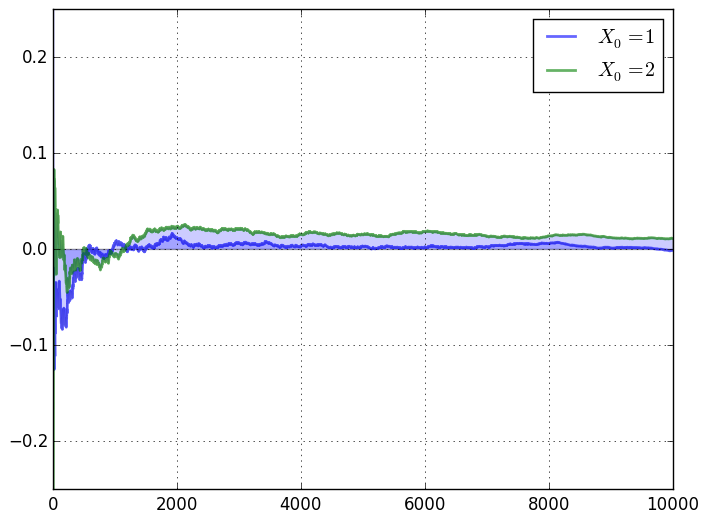

PyObject <matplotlib.legend.Legend object at 0x7f5dc72c3a90>

In [152]:
# Exercise 1
using QuantEcon
using PyPlot

function simulate(P, n, x0)
    x = x0
    out = Array(Int64, n)
    out[1] = x
    for i in 1:n-1
        d = DiscreteRV(squeeze(P[x,:], 1))
        x = draw(d)
        out[i+1] = x
    end
    return out
end

function time_matching(a, val)
    n = length(a)
    hits = cumsum(a .== val)
    x = Array(Float64, n)
    for i in 1:n
        x[i] = hits[i]/i
    end
    return x
end

function plot_shaded(series, labelname, ax)
    n = length(series)
    ax[:plot](1:n, series, "-", linewidth=2, alpha=0.6, label=labelname)
    ax[:fill_between](1:n, series, zeros(n), alpha=0.2)
end

P = [.4 .6 ; .2 .8]
n = 10000
psteady = P[2,1]/(P[1,2] + P[2,1])

sim1 = simulate(P, n, 1)
x1 = time_matching(sim1, 1)
y1 = x1 - psteady

sim2 = simulate(P, n, 2)
x2 = time_matching(sim2, 1)
y2 = x2 - psteady

fig, ax = subplots()
ax[:set_ylim](-0.25, 0.25)
ax[:grid]("on")
plot_shaded(y1, L"$X_0 = 1$", ax)
plot_shaded(y2, L"$X_0 = 2$", ax)
ax[:legend]()

In [18]:
# Exercise 2
using QuantEcon

function get_encoding(filename)
    f = open(filename, "r")
    samp = matchall(r"\w", readline(f))
    enc = typeof(samp[1])
    close(f)
    return enc
end

function make_pagemap(filename)
    encode_in = get_encoding(filename)
    f = open(filename, "r")
    pagemap = Dict{encode_in, Array{encode_in, 1}}()
    for line in eachline(f)
        pagepair = matchall(r"\w", line)
        if haskey(pagemap, pagepair[1])
            push!(pagemap[pagepair[1]], pagepair[2])
        else
            pagemap[pagepair[1]] = [pagepair[2]]
        end
    end
    close(f)
    return pagemap
end

function display_map(d)
    for pagefrom in sort(collect(keys(d)))
        print(pagefrom, " => [")
        pagesto = d[pagefrom]
        for pageto in sort(pagesto)
            print("\"", pageto)
            if !is(pageto, sort(pagesto)[end]) print("\", ") end
        end
        println("\"]")
    end
end

function matrixmap(inmap)
    allpages = sort(collect(keys(inmap)))
    pagedict = Dict([(page, index) for (index, page) in enumerate(allpages)])
    n = length(allpages)
    outmat = zeros(Int64, n, n)
    for page in allpages
        rownum = pagedict[page]
        for pageto in inmap[page]
            colnum = pagedict[pageto]
            outmat[rownum, colnum] += 1
        end
    end
    return outmat
end

function markovmap(inmatrix)
    n = size(inmatrix, 1)
    markovout = Array(Float64, n, n)
    for row in 1:n
        rowsum = sum(inmatrix[row, :])
        markovout[row, :] = inmatrix[row, :] / rowsum
    end
    return markovout
end

function crawl(P, n, x0)
    x = x0
    out = Array(Int64, n)
    out[1] = x
    for i in 1:n-1
        d = DiscreteRV(squeeze(P[x,:], 1))
        x = draw(d)
        out[i+1] = x
    end
    return out
end

function crawlstats(pagemap, crawlpath)
    allpages = sort(collect(keys(pagemap)))
    pagedict = Dict([(index, pagename) for (index, pagename) in enumerate(allpages)])
    scoreboard = Dict{typeof(allpages[1]), Int64}()
    for step in crawlpath
        if haskey(scoreboard, pagedict[step])
            scoreboard[pagedict[step]] += 1
        else
            scoreboard[pagedict[step]] = 1
        end
    end
    return scoreboard
end

function display_scoreboard(board)
    allpages = sort(collect(keys(pagemap)))
    scores = sort(collect(zip(values(board),keys(board))), rev = true)
    println("Rank\tPage\tScore")
    for (i, (score, page)) in enumerate(scores)
        println("$i\t$page\t$score")
    end
end

pagemap = make_pagemap("web_graph_data.txt")
link_ints = matrixmap(pagemap)
P = markovmap(link_ints)
n = size(P, 1)

crawlpath = crawl(P, 1000000, 1)
scores = crawlstats(pagemap, crawlpath)
display_scoreboard(scores)

Rank	Page	Score
1	g	161107
2	j	159154
3	m	119715
4	n	108067
5	k	90392
6	b	83596
7	e	53370
8	i	53144
9	c	48369
10	h	45617
11	l	32338
12	d	30560
13	f	11719
14	a	2852


In [61]:
# Exercise 3
using Distributions
using QuantEcon

function approx_markov(rho, sigma_u, m=3, n=7)
    sigma_y = sqrt(sigma_u^2/(1-rho^2))
    # println("sigma_y = $sigma_y")
    d = Normal(0, sigma_u)
    x = linspace(-m*sigma_y, m*sigma_y, n)
    s = 2 * m * sigma_y / (n - 1)
    P = zeros(Float64, n, n)
    for i in 1:n
        for j in 1:n
            if j == 1
                P[i, j] = cdf(d, x[1] - rho*x[i] + s/2)
            elseif j == n
                P[i, j] = 1 - cdf(d, x[n] - rho*x[i] + s/2)
            else
                P[i, j] = cdf(d, x[j] - rho*x[i] + s/2) - cdf(d, x[j] - rho*x[i] - s/2)
            end
        end
    end
    return P
end

function print_markov(P, digits = 3)
    n = size(P, 1)
    for i in 1:n
        linebracket_left = (i == 1) ? "[[" : " ["
        linebracket_right = (i == n) ? "]]" : "]"
        print(linebracket_left)
        for j in 1:n
            print("$(round(P[i, j], digits))\t")
        end
        println(linebracket_right)
    end
end


P = approx_markov(0.8, 1, 3, 7)
print_markov(P)

[[0.434	0.499	0.066	0.001	0.0	0.0	0.0	]
 [0.067	0.499	0.4	0.033	0.0	0.0	0.0	]
 [0.002	0.119	0.57	0.293	0.015	0.0	0.0	]
 [0.0	0.006	0.196	0.595	0.196	0.006	0.0	]
 [0.0	0.0	0.015	0.293	0.57	0.119	0.0	]
 [0.0	0.0	0.0	0.033	0.4	0.499	0.001	]
 [0.0	0.0	0.0	0.001	0.066	0.499	0.033	]]


In [62]:
truncate(5784.183947, 3)

LoadError: `truncate` has no method matching truncate(::Float64, ::Int64)
while loading In[62], in expression starting on line 1